In [1]:
import pandas as pd
from typing import Dict, Any, Union, Optional
import json
from zipfile import ZipFile

In [2]:
def _flatten_query(q: Dict[str, Any]) -> Optional[Dict[str, int]]:
    if "index_winner" not in q:
        return None
    sent = {
        d["label"] if d["label"] != "center" else "head": d["index"]
        for d in q["target_indices"]
    }
    t = q["timestamp_query_generated"]
    dt = q["response_time"]
    label = q["alg_label"]
    return {
        "winner": q["index_winner"],
        "alg": label,
        "response_time": dt,
        **sent,
    }


def _munge(fname: str) -> pd.DataFrame:
    with ZipFile(fname) as zf:
        with zf.open(fname.replace(".zip", "")) as f:
            raw = json.load(f)

    assert raw.pop("meta") == {"status": "OK", "code": 200}
    assert len(raw) == 1
    rare = raw["participant_responses"]
    mrare = sum(rare.values(), [])
    medium = [_flatten_query(d) for d in mrare]
    mwell = [m for m in medium if m]
    df = pd.DataFrame(mwell)
    cols = ["head", "left", "right", "winner", "alg", "response_time"]
    assert set(df.columns) == set(cols)
    df["loser"] = df[["head", "left", "right", "winner"]].apply(
        lambda r: r["left"] if r["winner"] == r["right"] else r["right"], axis=1
    )
    return df[cols + ["loser"]]

In [3]:
fnames = [
    (0, "i0126.png"), (1, "i0208.png"), (2, "i0076.png"), (3, "i0326.png"),
    (4, "i0526.png"), (5, "i0322.png"), (6, "i0312.png"), (7, "i0036.png"),
    (8, "i0414.png"), (9, "i0256.png"), (10, "i0074.png"), (11, "i0050.png"),
    (12, "i0470.png"), (13, "i0022.png"), (14, "i0430.png"), (15, "i0254.png"),
    (16, "i0572.png"), (17, "i0200.png"), (18, "i0524.png"), (19, "i0220.png"),
    (20, "i0438.png"), (21, "i0454.png"), (22, "i0112.png"), (23, "i0494.png"),
    (24, "i0194.png"), (25, "i0152.png"), (26, "i0420.png"), (27, "i0142.png"),
    (28, "i0114.png"), (29, "i0184.png"),
]
smoothness = {idx: int(target.strip("i.png")) for idx, target in fnames}

In [4]:
df = _munge("next-fig3.json.zip")
df = df[df.alg == "RandomSampling"]
for col in ["head", "left", "right", "winner"]:
    df[f"{col}_x"] = df[col].apply(smoothness.get)
df.head()

,head,left,right,winner,alg,response_time,loser,head_x,left_x,right_x,winner_x
0,11,15,28,28,RandomSampling,7.262,15,50,254,114,114
4,9,15,25,25,RandomSampling,1.742,15,256,254,152,152
22,20,8,22,8,RandomSampling,1.613,22,438,414,112,414
25,15,3,16,3,RandomSampling,1.251,16,254,326,572,326
26,21,29,0,0,RandomSampling,2.233,29,454,184,126,126


In [5]:
df["head"].unique()

array([11,  9, 20, 15, 21, 13, 12,  6, 23,  3,  1, 17,  7, 25, 27, 19,  0,
       24, 26,  8, 28, 18, 10,  4, 22,  5, 14, 16, 29,  2])

In [6]:
df["head_x"].unique()

array([ 50, 256, 438, 254, 454,  22, 470, 312, 494, 326, 208, 200,  36,
       152, 142, 220, 126, 194, 420, 414, 114, 524,  74, 526, 112, 322,
       430, 572, 184,  76])

In [7]:
import numpy as np
d_hl = np.abs(df["head_x"] - df["left_x"])
d_hr = np.abs(df["head_x"] - df["right_x"])

correct  = (d_hl < d_hr) & (df["winner_x"] == df["left_x"])
correct |= (d_hr < d_hl) & (df["winner_x"] == df["right_x"])
assert 0 <= correct.min() <= correct.max() <= 1
df["correct"] = correct.astype(int)
correct.mean()

0.8347996089931574

51
[ 0.07074231 17.55473809]


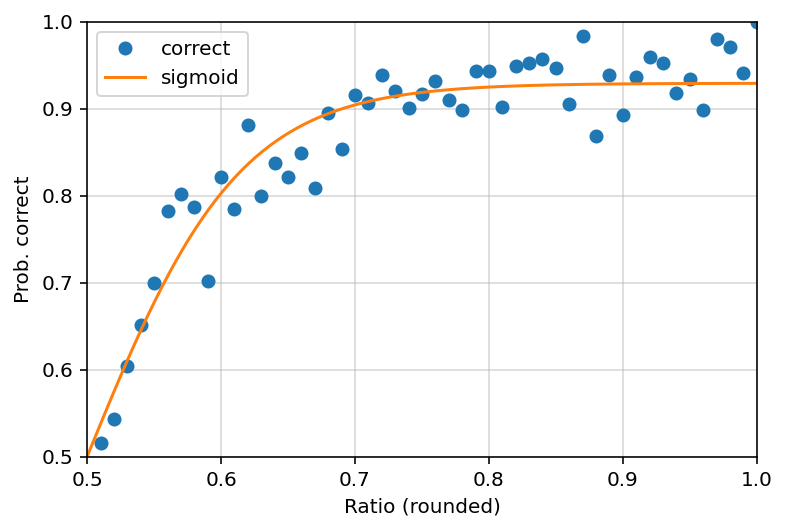

In [8]:
from scipy.optimize import curve_fit
factor = 10
df["ratio"] = np.maximum(d_hl, d_hr) / (d_hl + d_hr)
df["ratio_rounded"] = np.round(df["ratio"] * factor, decimals=1) / factor
print(df["ratio_rounded"].nunique())

def sigmoid(x, err=0.06, rate=13.0):
    noiseless = 1 / (1 + np.exp(-rate * (x - 0.5)))
    p_correct = (1 - err*2) * (noiseless - 0.5) + 0.5
    return p_correct

x = np.linspace(0.5, 1, num=100)
popt, pcov = curve_fit(sigmoid, df["ratio"], df["correct"], p0=(0.06, 13))
print(popt)
y = sigmoid(x, *popt)

ax = df.pivot_table(
    index="ratio_rounded",
    values="correct",
).plot(style="o")
ax.plot(x, y, label="sigmoid")
ax.legend(loc="best")

ax.set_xlim(0.5, 1)
ax.set_ylim(0.5, 1)
ax.set_xlabel("Ratio (rounded)")
ax.set_ylabel("Prob. correct")
ax.grid(alpha=0.5)